In [1]:
from utils import *

# Data preprocessing and loading for fast training

## Load source data

In [2]:
CONST_COLUMNS = [
    "Stellensubart_1",
    "Stellensubart_2",
    "Stellensubart_3",
    "Stellensubart_4",
    *[f"T{i}" for i in range(1, 35)],
    "Preis",
    "Beleuchtet",
    "Laenge",
    "Breite",
    "Eigenfläche",
    "PPSVACWert",
    "Qid",
    "GJ",
]
data = pd.read_pickle("data/df_gesamt_15_08_prepocessed_einworner_added.pkl")
target_year_having_qid = data[data.GJ == 2023].Qid
cleaned_data = data[data.Qid.isin(target_year_having_qid)]
cleaned_data = cleaned_data.sort_values(by=["Qid", "GJ"]).set_index("Qid", drop=False)
cleaned_data = cleaned_data.loc[:, CONST_COLUMNS]

## Load distance data

In [3]:
distance_2018 = pd.read_csv("./data/distances/distances_2018.csv").set_index("Qid1")
distance_2019 = pd.read_csv("./data/distances/distances_2019.csv").set_index("Qid1")
distance_2020 = pd.read_csv("./data/distances/distances_2020.csv").set_index("Qid1")
distance_2021 = pd.read_csv("./data/distances/distances_2021.csv").set_index("Qid1")
distance_2022 = pd.read_csv("./data/distances/distances_2022.csv").set_index("Qid1")

## Normalize cols

In [4]:
cleaned_data.Preis = (
    cleaned_data.Preis - cleaned_data.Preis.mean()
) / cleaned_data.Preis.std()

cleaned_data.Laenge = (cleaned_data.Laenge - (-180.0)) / (2 * 180.0)
cleaned_data.Breite = (cleaned_data.Breite - (-90.0)) / (2 * 90.0)

cleaned_data.PPSVACWert = (
    cleaned_data.PPSVACWert - cleaned_data.PPSVACWert.mean()
) / cleaned_data.PPSVACWert.std()

In [5]:
cleaned_data.loc[:, "T1":"T22"] = cleaned_data.loc[:, "T1":"T22"].replace(-1, 0)

## Split data into years

In [6]:
data_2018 = cleaned_data[cleaned_data.GJ == 2018].drop(columns=["Qid", "GJ"]).copy()
data_2019 = cleaned_data[cleaned_data.GJ == 2019].drop(columns=["Qid", "GJ"]).copy()
data_2020 = cleaned_data[cleaned_data.GJ == 2020].drop(columns=["Qid", "GJ"]).copy()
data_2021 = cleaned_data[cleaned_data.GJ == 2021].drop(columns=["Qid", "GJ"]).copy()
data_2022 = cleaned_data[cleaned_data.GJ == 2022].drop(columns=["Qid", "GJ"]).copy()
data_2023 = cleaned_data[cleaned_data.GJ == 2023].drop(columns=["Qid", "GJ"]).copy()

## Calculate label

In [7]:
data_2023["target"] = data_2023.loc[:, "T1":"T22"].mean(axis=1)

## Train / Validation split

In [8]:
all_valid_qids = cleaned_data.Qid.unique()
qid_train, qid_val = train_test_split(
    all_valid_qids, test_size=0.1, random_state=2023
)

## Data Loading

In [9]:
all_year_data = [
    data_2018,
    data_2019,
    data_2020,
    data_2021,
    data_2022,
]

In [10]:
def preprocess_data(qids, all_year_data, data_2023):
    columns_to_drop = ["PPSVACWert", *[f"T{i}" for i in range(1, 35)], "target"]

    X, x, y = [], [], []

    for idx, qid in enumerate(tqdm(qids)):
        features = []

        for year_data in all_year_data:
            
            try:
                features.append(torch.from_numpy(year_data.loc[qid].values))
            except KeyError:
                features.append(torch.zeros(44))
            
            
        self_data_2023 = torch.from_numpy(
            data_2023.loc[qid].drop(labels=columns_to_drop).values
        )
        
        features = torch.stack(features, dim=0)
        label = torch.tensor([data_2023.loc[qid, "target"]])

        X.append(features)
        x.append(self_data_2023)
        y.append(label)

    X = torch.stack(X, dim=0)
    x = torch.stack(x, dim=0)
    y = torch.stack(y, dim=0)

    return X, x, y


### Train data

In [11]:
X_train, x_train, y_train = preprocess_data(
    qid_train, all_year_data, data_2023
)

100%|█████████████████████████████████| 122307/122307 [00:44<00:00, 2732.38it/s]


In [12]:
torch.save(X_train, "./data/proof_of_concept/X_train_lstm_without_neighbours.pt")
torch.save(x_train, "./data/proof_of_concept/x_train_lstm_without_neighbours.pt")
torch.save(y_train, "./data/proof_of_concept/y_train_lstm_without_neighbours.pt")

### Validation data

In [13]:
X_val, x_val, y_val = preprocess_data(
    qid_val, all_year_data, data_2023
)

torch.save(X_val, "./data/proof_of_concept/X_val_lstm_without_neighbours.pt")
torch.save(x_val, "./data/proof_of_concept/x_val_lstm_without_neighbours.pt")
torch.save(y_val, "./data/proof_of_concept/y_val_lstm_without_neighbours.pt")

100%|███████████████████████████████████| 13590/13590 [00:04<00:00, 2844.16it/s]


### Test data

In [14]:
# X_test, x_test, y_test = preprocess_data(
#     [9860, 9673, 9855, 9333], all_year_data, all_year_distances, data_2023
# )

# torch.save(X_test, "./data/proof_of_concept/X_test_lstm_year_price.pt")
# torch.save(x_test, "./data/proof_of_concept/x_test_lstm_year_price.pt")
# torch.save(y_test, "./data/proof_of_concept/y_test_lstm_year_price.pt")

# Preparation for training

In [39]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.,
        )
        
        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size + 9, hidden_size // 2),
            nn.Sigmoid(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.06),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.Sigmoid(),
            nn.BatchNorm1d(hidden_size // 4),
            nn.Dropout1d(0.06),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.Sigmoid(),
            nn.BatchNorm1d(hidden_size // 8),
            nn.Dropout1d(0.06),
            nn.Linear(hidden_size // 8, output_size),
        )

    def forward(self, x, x_target):

        out, _ = self.lstm(x)
        out = out[:, -1, ...]
        out = torch.cat([out, x_target], dim=-1)
        out = self.fc_2(out)

        return out

In [40]:
class CustomDataset(Dataset):
    def __init__(
        self,
        path_X,
        path_x,
        path_y,
    ):
        self.data_X = torch.load(path_X).to(dtype=torch.float32)
        self.data_x = torch.load(path_x).to(dtype=torch.float32)
        self.data_y = torch.load(path_y).to(dtype=torch.float32)


    def __getitem__(self, index):
        X, x, y = (
            self.data_X[index].clone(),
            self.data_x[index].clone(),
            self.data_y[index].clone(),
        )
        
        return X, x, y

    def __len__(self):
        return len(self.data_X)

In [41]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [42]:
model = LSTMModel(44, 512, 5, 1).to(DEVICE)
criterion = nn.MSELoss()

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [44]:
train_dataset = CustomDataset(
    "./data/proof_of_concept/X_train_lstm_without_neighbours.pt",
    "./data/proof_of_concept/x_train_lstm_without_neighbours.pt",
    "./data/proof_of_concept/y_train_lstm_without_neighbours.pt",
)

val_dataset = CustomDataset(
    "./data/proof_of_concept/X_val_lstm_without_neighbours.pt",
    "./data/proof_of_concept/x_val_lstm_without_neighbours.pt",
    "./data/proof_of_concept/y_val_lstm_without_neighbours.pt",
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

print(f"Total training instances:\t{train_dataset.data_X.shape[0]}")
print(f"Total validation instances:\t{val_dataset.data_X.shape[0]}")

Total training instances:	122307
Total validation instances:	13590


# Training

In [45]:
num_epochs = 200
history = []
val_min_loss = float("+inf")

model_name = ""

while model_name == "":
    model_name = input("Input proper model name:\t")

Input proper model name:	testo


In [46]:
for epoch in range(num_epochs):
    mean_train_loss = train(model, train_dataloader, criterion, optimizer)
    mean_val_loss = validate(model, val_dataloader, criterion)

    history.append([mean_train_loss, mean_val_loss])
    print(
        f"Epoch [{epoch+1}/{num_epochs}]\nTrain Loss: {round(mean_train_loss, 4)}\nVal Loss: {round(mean_val_loss, 4)}"
        f"\nBest Val loss: {round(val_min_loss, 4)}"
    )

    if mean_val_loss < val_min_loss:
        val_min_loss = mean_val_loss
        print("Saving best model....")
        torch.save(model.state_dict(), f"./models/{model_name}_best.pt")

100%|████████████████████████████████████████| 213/213 [00:00<00:00, 711.10it/s]


Epoch [1/200]
Train Loss: 0.0338
Val Loss: 0.0222
Best Val loss: inf
Saving best model....


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 711.36it/s]


Epoch [2/200]
Train Loss: 0.0271
Val Loss: 0.024
Best Val loss: 0.0222


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 700.70it/s]


Epoch [3/200]
Train Loss: 0.0264
Val Loss: 0.0217
Best Val loss: 0.0222
Saving best model....


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.08it/s]


Epoch [4/200]
Train Loss: 0.0261
Val Loss: 0.0189
Best Val loss: 0.0217
Saving best model....


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.44it/s]


Epoch [5/200]
Train Loss: 0.0256
Val Loss: 0.021
Best Val loss: 0.0189


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 709.49it/s]


Epoch [6/200]
Train Loss: 0.0254
Val Loss: 0.0178
Best Val loss: 0.0189
Saving best model....


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 709.25it/s]


Epoch [7/200]
Train Loss: 0.025
Val Loss: 0.0184
Best Val loss: 0.0178


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 709.02it/s]


Epoch [8/200]
Train Loss: 0.0247
Val Loss: 0.0216
Best Val loss: 0.0178


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 709.91it/s]


Epoch [9/200]
Train Loss: 0.0245
Val Loss: 0.0168
Best Val loss: 0.0178
Saving best model....


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 699.16it/s]


Epoch [10/200]
Train Loss: 0.0242
Val Loss: 0.0168
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 700.42it/s]


Epoch [11/200]
Train Loss: 0.0238
Val Loss: 0.0198
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 699.19it/s]


Epoch [12/200]
Train Loss: 0.0234
Val Loss: 0.0174
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 697.75it/s]


Epoch [13/200]
Train Loss: 0.0229
Val Loss: 0.0171
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 697.07it/s]


Epoch [14/200]
Train Loss: 0.0229
Val Loss: 0.0172
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 696.10it/s]


Epoch [15/200]
Train Loss: 0.0225
Val Loss: 0.0177
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 697.96it/s]


Epoch [16/200]
Train Loss: 0.022
Val Loss: 0.0175
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 698.51it/s]


Epoch [17/200]
Train Loss: 0.0214
Val Loss: 0.0182
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 698.03it/s]


Epoch [18/200]
Train Loss: 0.0211
Val Loss: 0.0174
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 696.53it/s]


Epoch [19/200]
Train Loss: 0.0206
Val Loss: 0.0181
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 698.45it/s]


Epoch [20/200]
Train Loss: 0.0203
Val Loss: 0.0178
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 698.01it/s]


Epoch [21/200]
Train Loss: 0.0197
Val Loss: 0.0177
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 698.27it/s]


Epoch [22/200]
Train Loss: 0.0191
Val Loss: 0.0194
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 698.54it/s]


Epoch [23/200]
Train Loss: 0.0187
Val Loss: 0.0183
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 698.41it/s]


Epoch [24/200]
Train Loss: 0.0183
Val Loss: 0.0181
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 697.19it/s]


Epoch [25/200]
Train Loss: 0.0177
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 696.90it/s]


Epoch [26/200]
Train Loss: 0.0174
Val Loss: 0.0185
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 698.27it/s]


Epoch [27/200]
Train Loss: 0.0171
Val Loss: 0.0182
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 700.18it/s]


Epoch [28/200]
Train Loss: 0.0165
Val Loss: 0.0196
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 699.10it/s]


Epoch [29/200]
Train Loss: 0.0165
Val Loss: 0.0187
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 699.54it/s]


Epoch [30/200]
Train Loss: 0.0161
Val Loss: 0.0185
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 699.13it/s]


Epoch [31/200]
Train Loss: 0.0158
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.98it/s]


Epoch [32/200]
Train Loss: 0.0156
Val Loss: 0.0185
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 709.77it/s]


Epoch [33/200]
Train Loss: 0.0155
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.28it/s]


Epoch [34/200]
Train Loss: 0.0152
Val Loss: 0.0186
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 711.80it/s]


Epoch [35/200]
Train Loss: 0.0154
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.99it/s]


Epoch [36/200]
Train Loss: 0.0148
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.51it/s]


Epoch [37/200]
Train Loss: 0.0148
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 711.74it/s]


Epoch [38/200]
Train Loss: 0.0145
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 711.22it/s]


Epoch [39/200]
Train Loss: 0.0143
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.68it/s]


Epoch [40/200]
Train Loss: 0.0142
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.70it/s]


Epoch [41/200]
Train Loss: 0.0143
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.24it/s]


Epoch [42/200]
Train Loss: 0.014
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 710.66it/s]


Epoch [43/200]
Train Loss: 0.0139
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 711.77it/s]


Epoch [44/200]
Train Loss: 0.0139
Val Loss: 0.0193
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 699.08it/s]


Epoch [45/200]
Train Loss: 0.0139
Val Loss: 0.0194
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.13it/s]


Epoch [46/200]
Train Loss: 0.0138
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.25it/s]


Epoch [47/200]
Train Loss: 0.0137
Val Loss: 0.0197
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 698.85it/s]


Epoch [48/200]
Train Loss: 0.0137
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 699.77it/s]


Epoch [49/200]
Train Loss: 0.0134
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 699.51it/s]


Epoch [50/200]
Train Loss: 0.0134
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 708.77it/s]


Epoch [51/200]
Train Loss: 0.0137
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 708.21it/s]


Epoch [52/200]
Train Loss: 0.0137
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 705.85it/s]


Epoch [53/200]
Train Loss: 0.0132
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 705.79it/s]


Epoch [54/200]
Train Loss: 0.0134
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 705.74it/s]


Epoch [55/200]
Train Loss: 0.0132
Val Loss: 0.0193
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 705.42it/s]


Epoch [56/200]
Train Loss: 0.0132
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 706.78it/s]


Epoch [57/200]
Train Loss: 0.0132
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 709.35it/s]


Epoch [58/200]
Train Loss: 0.0137
Val Loss: 0.0208
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 699.81it/s]


Epoch [59/200]
Train Loss: 0.013
Val Loss: 0.0187
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 703.45it/s]


Epoch [60/200]
Train Loss: 0.013
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 703.75it/s]


Epoch [61/200]
Train Loss: 0.0129
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.54it/s]


Epoch [62/200]
Train Loss: 0.0133
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.63it/s]


Epoch [63/200]
Train Loss: 0.0129
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.19it/s]


Epoch [64/200]
Train Loss: 0.0129
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.76it/s]


Epoch [65/200]
Train Loss: 0.013
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 695.36it/s]


Epoch [66/200]
Train Loss: 0.0128
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.93it/s]


Epoch [67/200]
Train Loss: 0.0127
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.54it/s]


Epoch [68/200]
Train Loss: 0.0128
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.89it/s]


Epoch [69/200]
Train Loss: 0.0129
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 697.12it/s]


Epoch [70/200]
Train Loss: 0.0129
Val Loss: 0.0199
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.93it/s]


Epoch [71/200]
Train Loss: 0.013
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.92it/s]


Epoch [72/200]
Train Loss: 0.0127
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.42it/s]


Epoch [73/200]
Train Loss: 0.0127
Val Loss: 0.0196
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.01it/s]


Epoch [74/200]
Train Loss: 0.0127
Val Loss: 0.0196
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 703.28it/s]


Epoch [75/200]
Train Loss: 0.013
Val Loss: 0.0186
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.88it/s]


Epoch [76/200]
Train Loss: 0.0127
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.04it/s]


Epoch [77/200]
Train Loss: 0.0127
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.51it/s]


Epoch [78/200]
Train Loss: 0.0126
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.91it/s]


Epoch [79/200]
Train Loss: 0.0126
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.62it/s]


Epoch [80/200]
Train Loss: 0.0128
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.31it/s]


Epoch [81/200]
Train Loss: 0.0127
Val Loss: 0.0187
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.27it/s]


Epoch [82/200]
Train Loss: 0.0125
Val Loss: 0.0193
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.61it/s]


Epoch [83/200]
Train Loss: 0.0126
Val Loss: 0.0208
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.36it/s]


Epoch [84/200]
Train Loss: 0.0126
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.34it/s]


Epoch [85/200]
Train Loss: 0.0126
Val Loss: 0.0187
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.98it/s]


Epoch [86/200]
Train Loss: 0.0125
Val Loss: 0.0187
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.09it/s]


Epoch [87/200]
Train Loss: 0.0129
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.21it/s]


Epoch [88/200]
Train Loss: 0.0127
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 713.51it/s]


Epoch [89/200]
Train Loss: 0.0124
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 712.92it/s]


Epoch [90/200]
Train Loss: 0.0124
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 703.53it/s]


Epoch [91/200]
Train Loss: 0.0127
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 704.98it/s]


Epoch [92/200]
Train Loss: 0.0126
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 704.30it/s]


Epoch [93/200]
Train Loss: 0.0126
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.73it/s]


Epoch [94/200]
Train Loss: 0.0121
Val Loss: 0.0187
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.77it/s]


Epoch [95/200]
Train Loss: 0.0123
Val Loss: 0.0187
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 703.85it/s]


Epoch [96/200]
Train Loss: 0.0126
Val Loss: 0.0203
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.79it/s]


Epoch [97/200]
Train Loss: 0.0127
Val Loss: 0.0209
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.42it/s]


Epoch [98/200]
Train Loss: 0.0125
Val Loss: 0.0187
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.73it/s]


Epoch [99/200]
Train Loss: 0.0123
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 703.28it/s]


Epoch [100/200]
Train Loss: 0.0125
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.01it/s]


Epoch [101/200]
Train Loss: 0.0126
Val Loss: 0.0203
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.73it/s]


Epoch [102/200]
Train Loss: 0.0127
Val Loss: 0.0195
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 703.06it/s]


Epoch [103/200]
Train Loss: 0.0128
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.55it/s]


Epoch [104/200]
Train Loss: 0.0125
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.31it/s]


Epoch [105/200]
Train Loss: 0.0124
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.60it/s]


Epoch [106/200]
Train Loss: 0.0125
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.45it/s]


Epoch [107/200]
Train Loss: 0.0125
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.33it/s]


Epoch [108/200]
Train Loss: 0.0127
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.21it/s]


Epoch [109/200]
Train Loss: 0.0126
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.47it/s]


Epoch [110/200]
Train Loss: 0.0128
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 700.39it/s]


Epoch [111/200]
Train Loss: 0.0127
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 712.34it/s]


Epoch [112/200]
Train Loss: 0.0127
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 712.96it/s]


Epoch [113/200]
Train Loss: 0.0126
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 700.42it/s]


Epoch [114/200]
Train Loss: 0.0125
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.74it/s]


Epoch [115/200]
Train Loss: 0.0124
Val Loss: 0.0189
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.99it/s]


Epoch [116/200]
Train Loss: 0.0128
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 700.82it/s]


Epoch [117/200]
Train Loss: 0.0125
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.92it/s]


Epoch [118/200]
Train Loss: 0.0127
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 703.22it/s]


Epoch [119/200]
Train Loss: 0.0126
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 703.98it/s]


Epoch [120/200]
Train Loss: 0.0127
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.04it/s]


Epoch [121/200]
Train Loss: 0.0126
Val Loss: 0.0193
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 713.28it/s]


Epoch [122/200]
Train Loss: 0.0126
Val Loss: 0.0195
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 714.53it/s]


Epoch [123/200]
Train Loss: 0.0125
Val Loss: 0.0194
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 700.73it/s]


Epoch [124/200]
Train Loss: 0.0125
Val Loss: 0.0193
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.23it/s]


Epoch [125/200]
Train Loss: 0.0125
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.81it/s]


Epoch [126/200]
Train Loss: 0.0127
Val Loss: 0.0197
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.39it/s]


Epoch [127/200]
Train Loss: 0.0125
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.26it/s]


Epoch [128/200]
Train Loss: 0.0125
Val Loss: 0.0191
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 701.16it/s]


Epoch [129/200]
Train Loss: 0.0128
Val Loss: 0.019
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 485.68it/s]


Epoch [130/200]
Train Loss: 0.0128
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 702.20it/s]


Epoch [131/200]
Train Loss: 0.0126
Val Loss: 0.0192
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 714.61it/s]


Epoch [132/200]
Train Loss: 0.0124
Val Loss: 0.0188
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 714.78it/s]


Epoch [133/200]
Train Loss: 0.0129
Val Loss: 0.0203
Best Val loss: 0.0168


100%|████████████████████████████████████████| 213/213 [00:00<00:00, 497.72it/s]


Epoch [134/200]
Train Loss: 0.0127
Val Loss: 0.0202
Best Val loss: 0.0168


 13%|████▉                                  | 243/1912 [00:01<00:09, 167.80it/s]


KeyboardInterrupt: 

In [47]:
torch.save(model.state_dict(), f"./models/{model_name}_last.pt")

In [48]:
best_weights = torch.load(f"./models/{model_name}_best.pt")
model.load_state_dict(best_weights)

<All keys matched successfully>

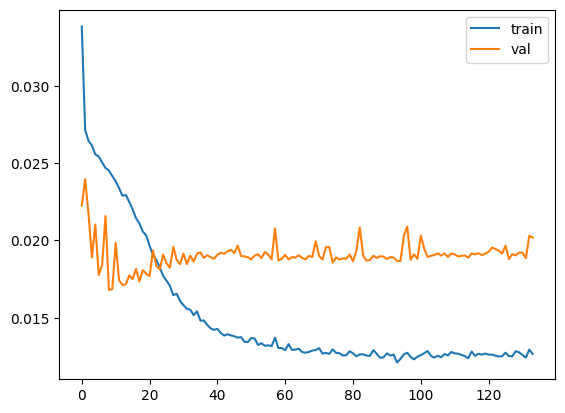

In [49]:
plt.plot(history)
plt.legend(["train", "val"])

# Evaluation

In [50]:
model.eval()

X_val = val_dataset.data_X
x_val = val_dataset.data_x
y_val = val_dataset.data_y

predictions = model(X_val.to(DEVICE), x_val.to(DEVICE)).detach().cpu().numpy()
ground_truth = y_val.numpy()

### MAE

In [51]:
print(np.abs(predictions - ground_truth).mean().round(4))

0.0992


### $R^{2}$

In [52]:
r2_score(ground_truth.flatten(), predictions.flatten())

0.7220172077011814

## Kernel Density Estimation plot

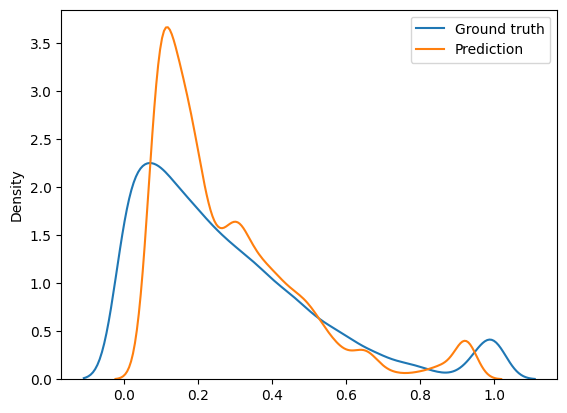

In [53]:
sns.kdeplot(ground_truth.flatten())
sns.kdeplot( predictions.flatten())
plt.legend(["Ground truth", "Prediction"])
plt.show()

## Scatter plot of ground_truth and preds

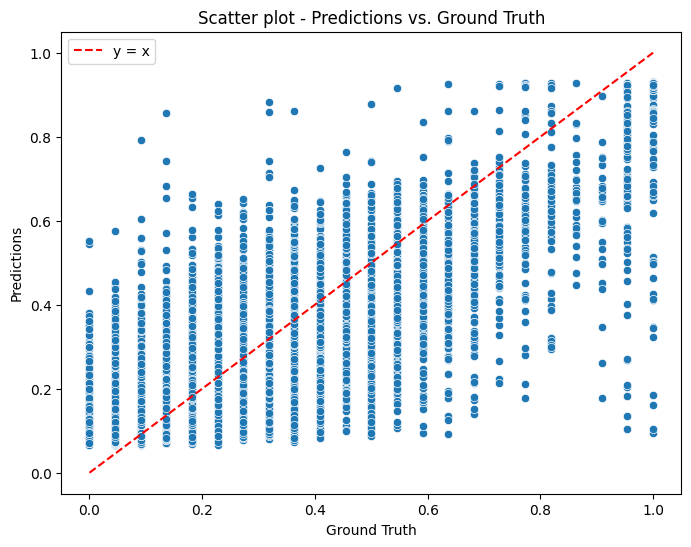

In [54]:
x_values = np.linspace(
    min(predictions.min(), ground_truth.min()),
    max(predictions.max(), ground_truth.max()),
    1_000,
)
y_values = x_values

plt.figure(figsize=(8, 6))
sns.scatterplot(x=ground_truth.flatten(), y=predictions.flatten())

plt.plot(x_values, y_values, color="red", linestyle="dashed", label="y = x")

plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Scatter plot - Predictions vs. Ground Truth")
plt.legend()
plt.show()